# EasyGuide to ESG
- AI를 활용하여 지속가능경영보고서를 분석하고 기업별 ESG 키워드를 통해 투자자들에게 정보 제공
- 데이터로 자체 학습한 gensim Word2Vec과 비지도학습 기법으로 가장 중요한 키워드를 추출하는 KRWordRank 활용

## 1. Library & Data

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_pandas
import rhinoMorph
from krwordrank.word import KRWordRank
from krwordrank.hangle import normalize      # 숫자, 영어 포함 여부
from krwordrank.word import summarize_with_keywords
from itertools import chain, repeat
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import random

In [2]:
# 경로 설정
os.chdir('../data/final_data/')

In [3]:
# 데이터프레임에 전체 보고서 이름과 연도, 텍스트 합치기
year = [str(x) for x in range(2018, 2022)]   # 연도 설정 : 2018 ~ 2021
df = pd.DataFrame(columns = ['year', 'fileName', 'text', 'rhino_preprocessing', 'keywords'])

for y in tqdm(year):
    fileList = os.listdir('./' + y)
    for file in fileList:
        with open('./' + y + '/' + file, 'r') as f:
            text = f.read().splitlines()
        if text and text[0].strip():
            df_slice = pd.Series([y, file, text[0].strip(), 0, 0], index = df.columns)
            df = df.append(df_slice, ignore_index = True)
df.head()

100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


,year,fileName,text,rhino_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,0,0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,0,0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,0,0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,0,0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,0,0


## 2. Exploratory Data Analysis (EDA)

In [4]:
df.text[0][:500]

'지속가능경영 보고서   목차                             보고서개요                 기관소개  지속가능경영 소개  경영추진체계 거버넌스 윤리경영 이해관계자 소통 중대성평가  청년 일자리지원 사업  중소기업 인적자원 개발지원 실력중심 사회조성 기반 마련 임직원이 행복한 일터 고객과 함께하는    경영 지역사회 상생협력  동반성장 친환경 실천문화            공단 소속기관 위치                     대원칙                                                                   전 국민의 평생고용역량을 키우는    .      파트너   한국산업인력공단에  관심과 애정으로 응원해주신 여러분들께 감사합니다.   지속되는 경제 불황 및 고용 없는 성장으로 인해 질 좋은 일자리 부족  청년  실업 등 많은 사회적 문제가 발생하고 있습니다. 또한  차 산업혁명으로 인한  인공지능  로봇 기술의 '

In [5]:
df.text[1][:500]

'-                                         보고서 개요  본 보고서는       가 발간하는 두 번째 보고서로서        의 지속가능경영 전략을 소개  하고 이를 실현하기 위한 영역별 지속가능경영 활동과 성과를 중심으로 구성하였습니다.       는 중대성 평가를 통해 자사와 이해관계자에게 우선적으로 중요하다고 판단 되는 정보를 수록하고자 노력하였으며  평가 결과는 현업 유관부서와의 리뷰와 경영진  검토를 통해 최종 확정하여 보고서에 담았습니다. 또한                            비전 아래 더 나은 삶을 위한 기술  혁신적인 플 랫폼 서비스를 통해       가 고객의 비즈니스를 선도하고 미래를 어떻게 준비하고  있는지를 알 수 있도록 하였습니다.       는 경제  사회  환경적 가치를 균형 있게 공 개하고자 하였으며  전사적으로 지속가능경영을 추진하고 있습니다.  보고서 기준 본 보고서는 국제 지속가능경영보고서 지침인   '

보고서 raw text의 최대 길이 : 550405
보고서 raw text의 평균 길이 : 123533.27118644067


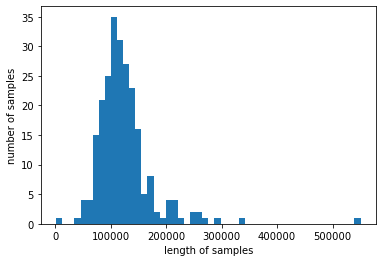

In [6]:
print('보고서 raw text의 최대 길이 :', max(len(l) for l in df.text))
print('보고서 raw text의 평균 길이 :', sum(map(len, df.text)) / len(df.text))
plt.hist([len(s) for s in df.text], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 3. Data Preprocessing

### (1) 정규표현식과 형태소 분석기를 이용한 데이터 전처리
1. 형태소 분석 없이 정규표현식만 사용한 전처리
2. 일반적으로 빠르고 성능이 좋다고 알려진 Mecab 형태소 분석기와 정규표현식을 사용한 전처리
    - 조사, 형식 형태소 등 의미없는 token이 많음
3. 품사 설정이 가능하고 정교한 customizing이 가능한 Rhino 형태소 분석기와 정규표현식을 사용한 전처리
    - 품사 설정이 가능하여 조사, 형식 형태소 등을 사전에 제외하므로 stopwords(불용어) 설정하는데 수월함
    
> 위 3가지 전처리 방법 중 3번이 가장 성능이 좋았기 때문에(키워드 추출이 가장 잘 됨) **3번**으로 진행

In [7]:
rn = rhinoMorph.startRhino()   # Rhino 형태소 분석기 객체 선언

def preprocessing_regex_rhino_All(text):
    
    afterText = re.sub('[^가-힣]', ' ', text)                # 한글만 남기기
    afterText = re.sub('/\r\n|\r|\n/', ' ', afterText)      # 개행문자 제거
    afterText = re.sub(' +', ' ', afterText)                # 연속된 공백 한개의 공백으로 변경
    
    # 실질형태소만, 동사의 어말어미 포함, 조사 제외
    # eomi=True : 동사, 형용사 계열 뒤에 모두 '-다'를 붙여주는 것
    # combineN=True : (default)False, 명사가 붙어있을 때, 하나의 형태소로 보는 것(더 나은 결과 도출)
    result = rhinoMorph.onlyMorph_list(rn, afterText, pos = ['NNG', 'NNP', 'NP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi = True, combineN = True, xrVv = True)
    
    return [word for word in result if len(word) > 1]       # 1글자는 제외

filepath:  /opt/anaconda3/lib/python3.8/site-packages
classpath:  /opt/anaconda3/lib/python3.8/site-packages/rhinoMorph/lib/rhino.jar
RHINO started!


In [8]:
tqdm.pandas()

df['rhino_preprocessing'] = df['text'].progress_apply(preprocessing_regex_rhino_All)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


,year,fileName,text,rhino_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서개요, 기관소개, 지속가능경영, 소개, 경영추...",0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 보다, 보고서, 발간하다, 보고서, 지속가능경영, 전략, 소개, ...",0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영보고서, 보다, 보다, 서다, 잇다, 보고서, 개요, 한국국토정보공, ...",0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데건설, 지속가능경영보고서, 보고서, 개요, 보고서, 특징, 롯데건설, 이후, ...",0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[보다, 서울특별시, 영등포구, 여의다, 투자증권빌딩, 투자증권, 지속가능경영보고서...",0


### (2) 보고서 이름을 기업명으로 변경하고 연도 변경
- 수작업으로 [지속가능경영보고서 DB](https://www.ksa.or.kr/ksi/4982/subview.do)와 비교, 대조하여 연도와 기업 이름 수정
1. 전체 260개 중에서 7개는 중복된 보고서이거나, 보고서 이름으로 기업명을 알아볼 수 없어서 제외
2. 지속가능성 보고서 DB의 조직명 기준으로 기업 이름 변경
3. 연도는 발행년도가 아닌 보고서 대상 연도로 변경

In [9]:
new_df = pd.read_excel("change_reportNames_final.xlsx")
nonExistReport = list(set(df['fileName'].values) - set(new_df['old_name'].values))   # df에 있지만 new_df에서 제외된 보고서

# new_df에서 제외된 보고서들을 df에서 삭제
drop_index = []
for extra in nonExistReport:
    drop_index.append(df[df['fileName'] == extra].index[0])

df = df.drop(drop_index).reset_index(drop = True)

for name in df['fileName'].values:
    df.loc[df['fileName'] == name, 'year'] = new_df.loc[new_df['old_name'] == name, 'year'].values[0]          # 연도 변경
    df.loc[df['fileName'] == name, 'fileName'] = new_df.loc[new_df['old_name'] == name, 'new_name'].values[0]  # 이름 변경
df_final = df.sort_values(['fileName', 'year']).reset_index(drop = True)  # new_name과 year 순으로 오름차순 정렬
df_final.loc[0, 'text'] = df_final.loc[0, 'text'][59:]
df_final.head()

,year,fileName,text,rhino_preprocessing,keywords
0,2019,BGF.txt,보고서 개요 본 보고서는 그룹사의 경제 사회 환경 분야의 성과를 통합...,"[보고서, 개요, 보다, 보고서, 그룹사, 경제, 사회, 환경, 분야, 성과, 통합...",0
1,2017,BNK금융그룹.txt,금융그룹 지속가능경영보고서 행 복 한 ...,"[금융그룹, 지속가능경영보고서, 보고서, 개요, 보다, 원칙, 기준, 금융그룹, 지...",0
2,2019,CJ대한통운.txt,본 보고서의 표지 및 내지는 ®인증 종이를 사용하고 있습니다. 또한 콩기름 ...,"[보고서, 표지, 인증, 종이, 사용하다, 또한, 콩기름, 잉크, 인쇄되다, 대한통...",0
3,2020,CJ대한통운.txt,보고서 개요 대한통운은 당사의 지속가능경영 활동 및 성과를 외부에 투명하게 공개...,"[보고서, 개요, 대한통운, 당사, 지속가능경영, 활동, 성과, 외부, 투명하다, ...",0
4,2020,CJ제일제당.txt,보고서 개요 제일제당은 매년 지속가능경영보고서를 발간하여 지속가능경영 활동과...,"[보고서, 개요, 제일제당, 매년, 지속가능경영보고서, 발간하다, 지속가능경영, 활...",0


### (3) Keyword 추출을 위한 Stopwords(불용어) 설정

In [10]:
origin_df = pd.read_excel('keywords_labeling.xlsx')
stop_df = origin_df[['words', 'count', 'stopwords', 'change']]
stop_df.fillna(1000, inplace = True)   # NaN값을 편리하게 처리하기 위해 1000으로 할당

stopwords_list = set(stop_df.loc[stop_df['stopwords'] != 1000, 'words'].values.tolist())
change_df = stop_df[stop_df['change'] != 1000]      # 60개 : 비지도학습을 활용한 KRWordRank의 결과값을 보완하기 위한 단어 변경 데이터

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## 4. Extract Keywords
### (1) KRWordRank
- 비지도학습으로 한국어 텍스트에서 키워드를 자동으로 추출해주는 라이브러리
- **주요 가정 : 단어 주변에는 단어가 등장하며, 올바른 단어는 주위의 많은 단어들과 연결되어 있다. 따라서 단어는 주위 단어들에 의하여 단어 점수가 보강(reinforced)된다.**
- [KR-WordRank Reference](https://github.com/lovit/KR-WordRank)
- [Setup]
```
pip install krwordrank
```
- vocabulary를 미리 설정하거나 decaying factor를 단어별로 다르게 (bias) 할당할 수 있으며, 모든 단어의 랭킹의 총합은 vocabulary size와 같음. 즉 default decaying factor는 1.0

In [11]:
# KRWordRank 파라미터 값 적용
def extract_keywords(text, stopwords_list):
    error_cnt = 0
    try:
        # substring graph를 만들기 위한 변수 값 설정
        min_count = 3       # 단어의 최소 출현 빈도수 (그래프 생성 시)
        max_length = 30     # 단어의 최대 길이
        verbose = False
        wordrank_extractor = KRWordRank(min_count, max_length, verbose)

        # graph ranking 알고리즘을 사용하여 단어 추출 (HITS algorithm)
        # substring graph에서 node(substring)의 랭킹을 계산하기 위해 graph ranking 알고리즘의 parameters 필요
        beta = 0.85         # PageRank의 decaying factor beta
        max_iter = 30

        keywords, rank, graph = wordrank_extractor.extract(text, beta, max_iter)

        stopwords = stopwords_list   # 불용어 설정
        keywords = summarize_with_keywords(text, min_count = 3, max_length = 30, beta = 0.85, max_iter = 30, stopwords = stopwords, verbose = False)
        result = sorted(keywords.items(), key = lambda x:x[1], reverse = True)   # 점수를 기준으로 내림차순 정렬

        return result       # 단어 & 점수
    
    except:
        error_cnt += 1
        print(error_cnt)
        
        return np.nan

In [12]:
df_final['keywords'] = df_final['rhino_preprocessing'].apply(lambda x: extract_keywords(x, stopwords_list))
df_final.head()

,year,fileName,text,rhino_preprocessing,keywords
0,2019,BGF.txt,보고서 개요 본 보고서는 그룹사의 경제 사회 환경 분야의 성과를 통합...,"[보고서, 개요, 보다, 보고서, 그룹사, 경제, 사회, 환경, 분야, 성과, 통합...","[(사회, 3.565704718205212), (운영, 3.5581694343454..."
1,2017,BNK금융그룹.txt,금융그룹 지속가능경영보고서 행 복 한 ...,"[금융그룹, 지속가능경영보고서, 보고서, 개요, 보다, 원칙, 기준, 금융그룹, 지...","[(금융, 23.950554429382937), (고객, 6.779315581020..."
2,2019,CJ대한통운.txt,본 보고서의 표지 및 내지는 ®인증 종이를 사용하고 있습니다. 또한 콩기름 ...,"[보고서, 표지, 인증, 종이, 사용하다, 또한, 콩기름, 잉크, 인쇄되다, 대한통...","[(안전, 8.20986713376673), (물류, 5.91408916901811..."
3,2020,CJ대한통운.txt,보고서 개요 대한통운은 당사의 지속가능경영 활동 및 성과를 외부에 투명하게 공개...,"[보고서, 개요, 대한통운, 당사, 지속가능경영, 활동, 성과, 외부, 투명하다, ...","[(안전, 10.75911521000984), (물류, 7.8506236958093..."
4,2020,CJ제일제당.txt,보고서 개요 제일제당은 매년 지속가능경영보고서를 발간하여 지속가능경영 활동과...,"[보고서, 개요, 제일제당, 매년, 지속가능경영보고서, 발간하다, 지속가능경영, 활...","[(지속, 6.777580628353339), (경영, 5.1051988732218..."


### (2) Keyword EDA
- 키워드의 발생 빈도 확인

In [13]:
# 중복 키워드 확인
keyword_counter = {}

for keywords in df_final.keywords:
    words, ranks = zip(*keywords)
    for word in words:
        keyword_counter[word] = keyword_counter.get(word, 0) + 1

keyword_counter = sorted(keyword_counter.items(), key = lambda x:x[1], reverse = True)
keyword_counter = list(keyword_counter)
len(keyword_counter)

3584

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


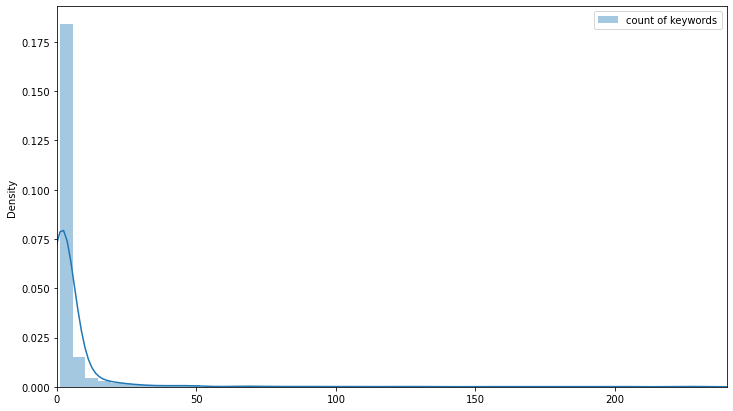

In [14]:
plt.figure(figsize = (12, 7))
sns.distplot(list(zip(*keyword_counter))[1], label = "count of keywords")
plt.xlim(0, 240)
plt.legend()

In [15]:
df_keyword_cnt = pd.DataFrame(list(zip(*keyword_counter))[1], columns = ['count'])
df_keyword_cnt['count'].describe()

count    3584.000000
mean        6.417969
std        21.740393
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       230.000000
Name: count, dtype: float64

## 5. Word2Vec model

전체 보고서 기반 형태소 분석된 데이터로 Word2Vec을 만들고, ESG 관련 유사 키워드 집합을 도출하여 그 키워드들에 대한 ESG 비율을 산출
- 주요 키워드는 논문을 참고하여 Environment, Social, Governance 각각 15개의 단어 추출
    1. 윤지혜, 이종화 (2021). 텍스트 마이닝을 활용한 기업의 CSR 키워드 일반화 연구. 인터넷전자상거래연구 , 21(4), 31-48.
    2. 안태욱, 이희승, 이준서 (2021). 연관규칙 분석을 통한 ESG 우려사안 키워드 도출에 관한 연구. 정보시스템연구 , 30(1), 123-149
- model.wv.most_similar()을 이용하여 0.7보다 큰 가중치를 가진 단어들로 추려 기준 단어로 설정
- 기준 단어들이 각 기업의 연도별 보고서에 존재하는 개수 Counting하여 E, S, G 비율 산정

### (1) 보고서 데이터 간략한 EDA

보고서의 최대 길이 : 51903
보고서의 평균 길이 : 18492.22077922078


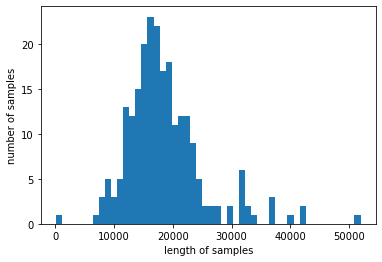

In [16]:
print('보고서의 최대 길이 :', max(len(l) for l in df_final.rhino_preprocessing))
print('보고서의 평균 길이 :', sum(map(len, df_final.rhino_preprocessing)) / len(df_final.rhino_preprocessing))
plt.hist([len(s) for s in df_final.rhino_preprocessing], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### (2) Word2Vec 생성

In [17]:
model = Word2Vec(sentences = df_final.rhino_preprocessing, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 1)
print(model.wv.vectors.shape)

(34287, 100)


### (3) 논문에서 추출한 ESG 단어와 유사한 keywords를 word2vec model로 추출

In [18]:
ESG_df = pd.read_excel('ESG_keywords.xlsx')
E = ESG_df['E'].values.tolist()
S = ESG_df['S'].values.tolist()
G = ESG_df['G'].values.tolist()

# 각 보고서에 있는 E, S, G 기준 단어 추출
thres = 0.7      # 기준 유사도 점수
standard_E = []
for words in E:
    similar_words = [E_word for E_word, E_score in model.wv.most_similar(words, topn = 1000) if E_score > thres]
    standard_E.extend(similar_words)
standard_E = list(set(standard_E))

standard_S = []
for words in S:
    similar_words = [S_word for S_word, S_score in model.wv.most_similar(words, topn = 1000) if S_score > thres]
    standard_S.extend(similar_words)
standard_S = list(set(standard_S))

standard_G = []
for words in G:
    similar_words = [G_word for G_word, G_score in model.wv.most_similar(words, topn = 1000) if G_score > thres]
    standard_G.extend(similar_words)
standard_G = list(set(standard_G))

In [19]:
tqdm.pandas()

df_final['Environment'] = df_final['rhino_preprocessing'].progress_apply(lambda x:[word for word in x if word in standard_E])
df_final['Social'] = df_final['rhino_preprocessing'].progress_apply(lambda x:[word for word in x if word in standard_S])
df_final['Governance'] = df_final['rhino_preprocessing'].progress_apply(lambda x:[word for word in x if word in standard_G])

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 231/231 [05:29<00:00,  1.43s/it]


In [20]:
# 중복 단어 제거
df_final['Environment'] = df_final['Environment'].apply(lambda x:list(set(x)))
df_final['Social'] = df_final['Social'].apply(lambda x:list(set(x)))
df_final['Governance'] = df_final['Governance'].apply(lambda x:list(set(x)))
df_final

,year,fileName,text,rhino_preprocessing,keywords,Environment,Social,Governance
0,2019,BGF.txt,보고서 개요 본 보고서는 그룹사의 경제 사회 환경 분야의 성과를 통합...,"[보고서, 개요, 보다, 보고서, 그룹사, 경제, 사회, 환경, 분야, 성과, 통합...","[(사회, 3.565704718205212), (운영, 3.5581694343454...","[탄소배출량, 브릿지, 전라북도, 온실가스, 풍력발전, 재난발생, 환경정화활동, 울...","[속가, 재난예방, 상생지원, 사회평가, 실천의지, 문화활동, 자금운용, 일류기업,...","[체질, 공정거래법규, 효율설비, 실천의지, 기업시민, 일류기업, 발돋움하다, 선포..."
1,2017,BNK금융그룹.txt,금융그룹 지속가능경영보고서 행 복 한 ...,"[금융그룹, 지속가능경영보고서, 보고서, 개요, 보다, 원칙, 기준, 금융그룹, 지...","[(금융, 23.950554429382937), (고객, 6.779315581020...","[창원, 온실, 옐로카드, 자원절감, 휘트니스센터, 온실가스, 안전용품, 진주, 근...","[조세정책, 사회적책임경영, 수익창출, 인식제고, 사고방식, 경영비전, 사회적책임,...","[종합금융그룹, 체질, 조세정책, 전자공, 리드하다, 동기대비, 금융정보, 성장기반..."
2,2019,CJ대한통운.txt,본 보고서의 표지 및 내지는 ®인증 종이를 사용하고 있습니다. 또한 콩기름 ...,"[보고서, 표지, 인증, 종이, 사용하다, 또한, 콩기름, 잉크, 인쇄되다, 대한통...","[(안전, 8.20986713376673), (물류, 5.91408916901811...","[온실가스, 예방계획, 안전지도, 안전대책, 소방, 안전운전, 안전확보, 수소, 신...","[고객정보보호, 창조적, 사회평가, 단체교섭권, 노인일자리, 꿈나무, 인식제고, 개...","[조직문화혁신, 안전지도, 기업시민, 통합관리시스템, 전운, 표명, 전략수립, 선포..."
3,2020,CJ대한통운.txt,보고서 개요 대한통운은 당사의 지속가능경영 활동 및 성과를 외부에 투명하게 공개...,"[보고서, 개요, 대한통운, 당사, 지속가능경영, 활동, 성과, 외부, 투명하다, ...","[(안전, 10.75911521000984), (물류, 7.8506236958093...","[온실가스, 예방계획, 현장안전관리, 멸종위기종, 안전대책, 소방, 수소, 신도시,...","[고객정보보호, 조세정책, 소통기반, 창조적, 단체교섭권, 조직문화, 공존하다, 반...","[신성장동력, 조세정책, 소통기반, 전자공, 금지사항, 현장안전관리, 기업시민, 표..."
4,2020,CJ제일제당.txt,보고서 개요 제일제당은 매년 지속가능경영보고서를 발간하여 지속가능경영 활동과...,"[보고서, 개요, 제일제당, 매년, 지속가능경영보고서, 발간하다, 지속가능경영, 활...","[(지속, 6.777580628353339), (경영, 5.1051988732218...","[바이오매스, 환경안전경영, 방재, 화석연료, 온실가스, 인권존중문화, 실행체계, ...","[윤리경영교육, 세계인, 고객정보보호, 조세정책, 긴밀히, 기본원칙, 일류기업, 불...","[경쟁업체, 조세정책, 전자공, 기본원칙, 일류기업, 기업시민, 보험요율, 촉진제,..."
...,...,...,...,...,...,...,...,...
226,2020,현대트랜시스.txt,현대트랜시스 지속가능경영보고서 보고서 개요 ...,"[지속가능경영보고서, 보고서, 개요, 보다, 보고서, 현대, 다양, 하다, 이해관계...","[(지속, 4.724782042291022), (안전, 4.4584278976587...","[온실, 환경오염물질, 온실가스, 공사안전, 안전보건의, 예방시설, 예방활동, 점검...","[창조적, 전진하, 조직몰입, 그랜트, 생존하다, 조직문화, 준법윤리경영, 자립지원...","[전진하, 신인도, 기업시민, 조직몰입, 준법윤리경영, 업무지침, 안전예방활동, 윤..."
227,2019,현대해상화재보험.txt,현대해상화재보험 지속가능성보고서 - ...,"[현대해상화재보험, 지속가능, 보고서, 보고서, 개요, 현대해상, 국내, 보험업, ...","[(보험, 7.6271598847778685), (고객, 6.448725354875...","[온실, 환경오염물질, 온실가스, 풍력발전, 환경투자, 대책수립, 횡단보도, 환경보...","[창조적, 고객정보보호, 처벌, 고객권익, 단체교섭권, 윤리의식, 윤리준법경영, 조...","[문화조성, 신인도, 부서단위, 기업시민, 자본력, 윤리의식, 윤리준법경영, 윤리경..."
228,2020,현대해상화재보험.txt,- 현대해상 지속가능성보고서 ...,"[현대해상, 지속가능, 보고서, 메시지, 기업소, 경영성과, 환경경영, 방침, 전략...","[(환경, 8.146406034679856), (경영, 6.9823492492038...","[보존하다, 자원절약, 온실가스, 풍력발전, 보전활동, 환경보호활동, 예방계획, 심...","[고객정보보호, 실천의지, 사회적약자, 서명기, 윤리의식, 개정하다, 윤리준법경영,...","[전자공, 실천의지, 부서단위, 적하보험, 업무담당자, 자본력, 윤리의식, 환경전,..."
229,2018,효성.txt,지속가능경영보고서 효성은 이해관계자와 적극적으...,"[지속가능경영보고서, 효성, 이해관계자, 적극적, 소통하다, 지속가능경영, 현황, ...","[(지속, 5.928559810140058), (효성, 5.6584189782257...","[취급물질, 온실가스, 전소, 소방, 비상대피훈련, 특별관리, 대피요령, 수소, 재...","[고객정보보호, 사회평가, 인권침해행위, 일류기업, 봉사하다, 수익창출, 고용조건,...","[체질, 신성장동력, 리드하다, 최고위, 사례교육, 성장기반, 일류기업, 사내게시판..."


## 6. Save

In [21]:
model.save('word2vec_model_final')

In [22]:
np.save('df_final_ESG', df_final)

## 7. Data for Visualization

### (1) dummy1_wordrank
- KRWordRank를 통해 추출한 각 보고서별 Top 키워드와 점수

In [23]:
corp_list = df_final[['fileName', 'year']].values.tolist()
corp_repeat = list(chain.from_iterable(repeat(corp, 20) for corp in corp_list))
dummy1_wr = pd.DataFrame(corp_repeat, columns = ['기업명', '시기'])
dummy1_wr['순서'] = list(chain.from_iterable(repeat(list(range(1, 21)), len(df_final))))
dummy1_wr = dummy1_wr.replace('.txt', '', regex = True)
dummy1_wr = dummy1_wr.drop(list(range(2242, 2260))).reset_index(drop = True)

# 키워드 & 점수 추출
words_list = []
scores_list = []
for keywords in df_final.keywords:
    words, scores = zip(*keywords)
    words_list.extend(words[:20])
    scores_list.extend(scores[:20])

dummy1_wr['키워드'] = words_list
dummy1_wr['점수'] = scores_list
dummy1_wr.drop('순서', axis = 1, inplace = True)

# 불완전한 keyword 변경
keyword_change = change_df[['words', 'change']].values.tolist()
keyword_change_dict = {}
for old, new in keyword_change:
    keyword_change_dict[old] = new

for index, k in enumerate(dummy1_wr['키워드']):
    confirm = keyword_change_dict.get(k, 0)
    if confirm != 0:
        dummy1_wr.iloc[index, 2] = confirm

# 점수 regularization
var = dummy1_wr['점수'].values.reshape(-1, 1)
min_max_scaler = MinMaxScaler()
var_scaling = min_max_scaler.fit_transform(var)
dummy1_wr['점수'] = var_scaling
dummy1_wr.to_excel(excel_writer = 'dummy1_final_wordrank.xlsx', index = False)

### (2) dummy1_ESG
- Word2Vec을 통해 추출한 각 보고서의 E, S, G 키워드와 점수

In [24]:
corp_list = df_final[['fileName', 'year']].values.tolist()
corp_repeat = list(chain.from_iterable(repeat(corp, 21) for corp in corp_list))
dummy1 = pd.DataFrame(corp_repeat, columns = ['기업명', '시기'])
dummy1['순서'] = list(chain.from_iterable(repeat(list(range(1, 22)), len(df_final))))
dummy1 = dummy1.replace('.txt', '', regex = True)
dummy1 = dummy1.drop([2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372]).reset_index(drop = True)   # 삼성화재(2018)의 12순서 ~ 21순서 삭제

keywords = []
for i in range(len(df_final)):
    if i == 112:  # 삼성화재(2018) 보고서의 ESG 키워드 12개밖에 없음
        keywords.extend(df_final.loc[i, 'Environment'])
        keywords.extend(df_final.loc[i, 'Social'])
        keywords.extend(df_final.loc[i, 'Governance'])
    else:
        sample_E = random.sample(df_final.loc[i, 'Environment'], 7)
        sample_S = random.sample(df_final.loc[i, 'Social'], 7)
        sample_G = random.sample(df_final.loc[i, 'Governance'], 7)
        keywords.extend(sample_E)
        keywords.extend(sample_S)
        keywords.extend(sample_G)

dummy1['키워드'] = keywords
dummy1 = dummy1.drop('순서', axis = 1)
scores = []
for _ in range(len(dummy1)):
    scores.append(random.randint(1, 15))
dummy1['점수'] = scores

# 색깔 추가
colors = ['green', 'blue', 'purple']
color_repeat = list(chain.from_iterable(repeat(color, 7) for color in colors))
color_repeat = list(chain.from_iterable(repeat(color_repeat, len(df_final))))
color_test = pd.DataFrame(color_repeat, columns = ['color'])
color_test.drop([2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372], inplace = True)
dummy1['색깔'] = color_test['color'].values.tolist()
dummy1.to_excel(excel_writer = 'dummy1_final.xlsx', index = False)

### (3) dummy2
- Word2Vec을 통해 추출한 각 보고서의 E, S, G 키워드의 비율

In [25]:
dummy2 = df_final[['fileName', 'year']]

# 단어 개수
dummy2['E_cnt'] = df_final['Environment'].apply(lambda x:int(len(x)))
dummy2['S_cnt'] = df_final['Social'].apply(lambda x:int(len(x)))
dummy2['G_cnt'] = df_final['Governance'].apply(lambda x:int(len(x)))

dummy2['E'] = 0
dummy2['S'] = 0
dummy2['G'] = 0

# E, S, G 비율 계산
for i in range(len(dummy2)):
    dummy2.iloc[i, 5] = int((dummy2.iloc[i, 2] / (dummy2.iloc[i, 2] + dummy2.iloc[i, 3] + dummy2.iloc[i, 4])) * 100)
    dummy2.iloc[i, 6] = int((dummy2.iloc[i, 3] / (dummy2.iloc[i, 2] + dummy2.iloc[i, 3] + dummy2.iloc[i, 4])) * 100)
    dummy2.iloc[i, 7] = int((dummy2.iloc[i, 4] / (dummy2.iloc[i, 2] + dummy2.iloc[i, 3] + dummy2.iloc[i, 4])) * 100)

dummy2_final = dummy2[['fileName', 'year', 'E', 'S', 'G']]
dummy2_final.replace('.txt', '', regex = True, inplace = True)
dummy2_final.rename(columns = {'fileName':'기업명', 'year':'시기'}, inplace = True)
dummy2_final.to_excel(excel_writer = 'dummy2_final.xlsx', index = False)

<ipython-input-25-7d35feae13ba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy2['E_cnt'] = df_final['Environment'].apply(lambda x:int(len(x)))
<ipython-input-25-7d35feae13ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy2['S_cnt'] = df_final['Social'].apply(lambda x:int(len(x)))
<ipython-input-25-7d35feae13ba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### (4) dummy3
- Word2Vec을 통해 추출한 각 보고서의 E, S, G 키워드

In [26]:
corp_list = dummy2_final[['기업명', '시기']].values.tolist()
corp_repeat = list(chain.from_iterable(repeat(corp, 5) for corp in corp_list))
dummy3 = pd.DataFrame(corp_repeat, columns = ['기업명', '시기'])
dummy3['순위'] = list(chain.from_iterable(repeat([1, 2, 3, 4, 5], len(dummy2_final))))
dummy3 = dummy3.drop([562, 563, 564]).reset_index(drop = True)   # 삼성화재(2018)의 3순위, 4순위, 5순위 삭제

E_keywords = []
S_keywords = []
G_keywords = []
for i in range(len(df_final)):
    if i == 112:  # 삼성화재(2018) 보고서의 E, S, G 키워드가 3개, 6개, 2개밖에 없으므로 2개씩만 sampling
        E_keywords.extend(df_final.loc[i, 'Environment'][:2])
        S_keywords.extend(df_final.loc[i, 'Social'][:2])
        G_keywords.extend(df_final.loc[i, 'Governance'])
    else:
        sample_E = random.sample(df_final.loc[i, 'Environment'], 5)
        sample_S = random.sample(df_final.loc[i, 'Social'], 5)
        sample_G = random.sample(df_final.loc[i, 'Governance'], 5)
        E_keywords.extend(sample_E)
        S_keywords.extend(sample_S)
        G_keywords.extend(sample_G)

dummy3['E'] = E_keywords
dummy3['S'] = S_keywords
dummy3['G'] = G_keywords
dummy3.to_excel(excel_writer = 'dummy3_final.xlsx', index = False)